In [1]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import itertools 
import warnings 
warnings.filterwarnings("ignore")

from pylab import rcParams
from google.cloud import bigquery

# INTRO
The aim of this project is to analyze time series with two different common forecasting methodologies / tools: ARIMA models and Facebook Prophet. We will take a dataset from bigquery, describing Iowa Liquor Sales. 
The aim will be to:
- Predict the trend of alcoholic beverage sales on a monthly basis
- For the next few years
- Keeping into account their trend, seasonality, and possibly other regressors that will contribute to explaining the trend (e.g. number of liquor stores)

In [2]:
client = bigquery.Client()

sql = '''
SELECT
--  date,
--  date_trunc(date, week) as week,
    date_trunc(date, month) as month,
    count(distinct store_number) as number_of_stores,
    sum(bottles_sold) as bottles_sold
FROM `bigquery-public-data.iowa_liquor_sales.sales` 
    group by 1 --,2,3
    order by 1 
'''

results = client.query(sql)
raw_data = results.to_dataframe()
iowa = raw_data

# 1 Time series Preprocessing
1) Be sure you have **no NULL dates** in your timeseries.  
In this case the transformation was performed straight into sql by grouping data at Month level (there were actually some null days)  
2) Your dataframe is indexed on a datetime type.  
3) Decompose and check for actual seasonality trends.

## 1.1. Check integrity

In [3]:
iowa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   month             102 non-null    object
 1   number_of_stores  102 non-null    int64 
 2   bottles_sold      102 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 2.5+ KB


## 1.2. Set datetime index

In [4]:
#set a datetime index, converting the current string 
datetime_idx = pd.to_datetime(iowa['month'])
iowa = iowa.set_index(datetime_idx)

#drop the month column
iowa = iowa.drop("month", axis=1)
iowa

,number_of_stores,bottles_sold
month,,
2012-01-01,973,1302231
2012-02-01,988,1457824
2012-03-01,1004,1458665
2012-04-01,1019,1588914
2012-05-01,1021,1782175
...,...,...
2020-02-01,1516,1996321
2020-03-01,1548,2406919
2020-04-01,1646,2451397


## 1.3. Evaluate seasonality

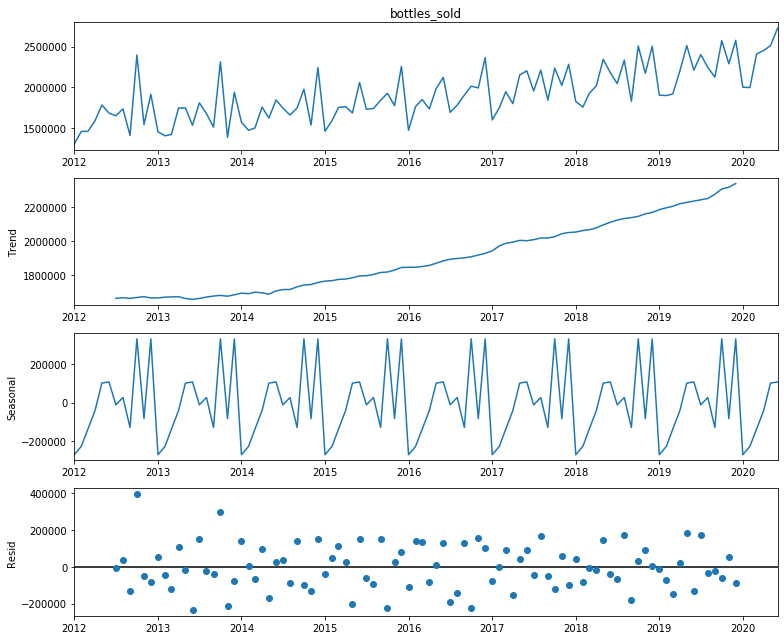

In [5]:
#set your y as the variable you are investigating for seasonality
y = iowa["bottles_sold"]

rcParams['figure.figsize'] = 11, 9

decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

Seems that people like to get wasted in october and in december (Legit)

# 2. Seasonal ARIMA model

The following explanation is taken fro the excellent [DigitalOcean article](https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3): 

There are three distinct integers (p, d, q) that are used to parametrize ARIMA models. Together these three parameters account for seasonality, trend, and noise in datasets:

- **p** is the auto-regressive part of the model. It allows us to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days.  

- **d** is the integrated part of the model. This includes terms in the model that incorporate the amount of differencing (i.e. the number of past time points to subtract from the current value) to apply to the time series. Intuitively, this would be similar to stating that it is likely to be same temperature tomorrow if the difference in temperature in the last three days has been very small.  

- **q** is the moving average part of the model. This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.


When dealing with seasonal effects, we make use of the seasonal ARIMA, which is denoted as:  
  
**ARIMA(p,d,q)(P,D,Q)s**.  

Here, (p, d, q) are the non-seasonal parameters described above, while (P, D, Q) follow the same definition but are applied to the seasonal component of the time series. *The term s is the periodicity of the time series (4 for quarterly periods, 12 for yearly periods, etc.).*

The seasonal ARIMA method can appear daunting because of the multiple tuning parameters involved. In the next section, we will describe how to automate the process of identifying the optimal set of parameters for the seasonal ARIMA time series model.


## 2.1. Optimal parameter tuning
Parameter tuning is done through a brute force approach. Check multiple combinations and evaluate what fits best the diagnostics.

In [6]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, d and q triplets, with a seasonality (s) of 12 months
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


Now run a brute force check on parameter optimization, that is running on all the combinations identified above.  
- Identify the lowest AIC choices for best fit.  
- Run a further check over the plot diagnostics.

In [7]:
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq: 
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue


SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:3213.830962061609
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:2782.9303341321693
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2399.191640414357
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:2079.7727329520867
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:2396.7130036980616
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:2369.8518802479275
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:2098.1157757549013
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:2077.4795837923502
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:3122.3771179734613
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2728.9262203087883
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:2373.173853936447
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:2054.175656077156
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:2779.5964227976187
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2719.8866739233736
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:2100.2128511862343
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:2048.990928312833
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:2837.4154859665396
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AI

Best AIC value is for SARIMA(1,1,1)X(0,1,1,12) - Let's try to get this model out.

In [8]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12), #look 1 year behind
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       bottles_sold   No. Observations:                  102
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -994.933
Date:                            Tue, 14 Jul 2020   AIC                           1997.866
Time:                                    18:41:58   BIC                           2007.136
Sample:                                01-01-2012   HQIC                          2001.567
                                     - 06-01-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3842      0.146     -2.623      0.009      -0.671      -0.097
ma.L1         -0.8750      0.058    -15.072      0.000      -0.989      -0.761
ma.S.L12       0.1410      0.127      1.107      0.268      -0.109       0.391
sigma2      2.574e+10   7.16e-13    3.6e+22      0.000    2.57e+10    2.57e+10
===================================================================================
Ljung-Box (Q):                       93.26   Jarque-Bera (JB):                 6.53
Prob(Q):                              0.00   Prob(JB):                         0.04
Heteroskedasticity (H):               1.14   Skew:                             0.67
Prob(H) (two-sided):                  0.75   Kurtosis:                         3.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.22e+38. Standard errors may be unstable.
"""

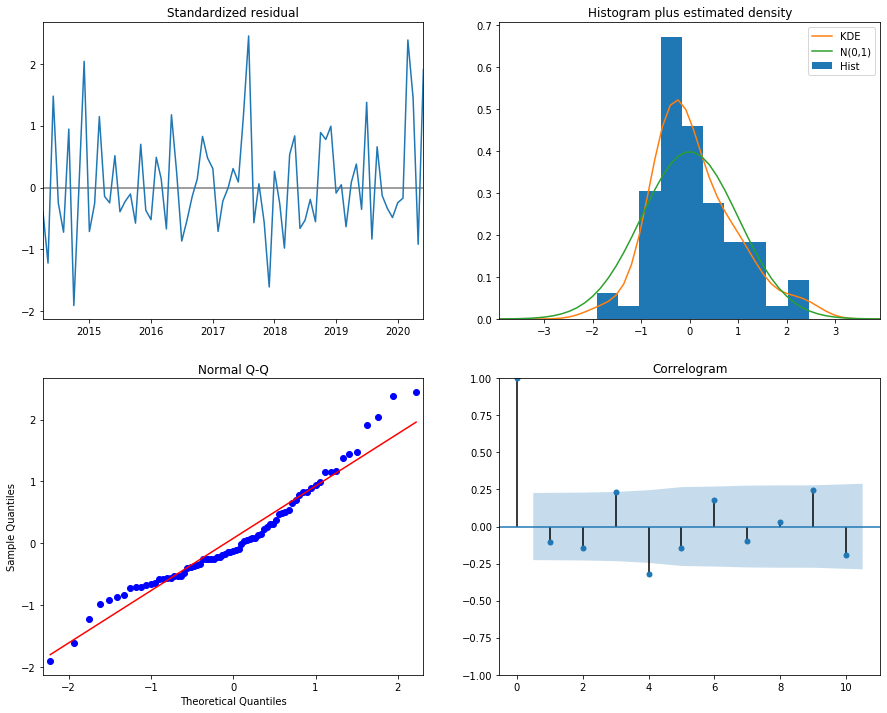

In [9]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()


Commenting the graphs, that address specifically the residuals of the model. We are checking they are NOT correlated and normally distributed with a mean of zero:
- No obvious seasonality in the residuals, meaning that they are mostly white noise.
- The correlogram however hints that there is a degree of correlation of the time series with themselves, in the sense they repeat in time as lagged version of themselves.
- qq plot shows that the distribution of residuals follows a linear trend, more or less. Same is for the KDE plot that mimicks decently a normal distribution.

We could probably get a better fit but let's go with this option.

# 3. Validate the forecast
Best way to check if your model makes some sense is to check and see how well it gets in line with actual data, that is, **comparing predicted vs actual values**.

## 3.1. Static forecast
Use all available data in a 'rolling' fashion, in order to predict the actual values. We:
- Set a starting point and call *get_prediction* over the model results.
- Use a static forecast, so that we use every point in the timeseries to forecast the next value. (one-step-ahead)
- Plot results
- Verify model goodness by checking MAE / RMSE / MAPE.


In [10]:
#let's start forecasting from 2018 onwards.
start = pd.to_datetime('2018-01-01')

pred = results.get_prediction(start= start, 
                              dynamic=False) #Every forecast value uses the full history available till that point. 

pred_ci = pred.conf_int(alpha=0.05)


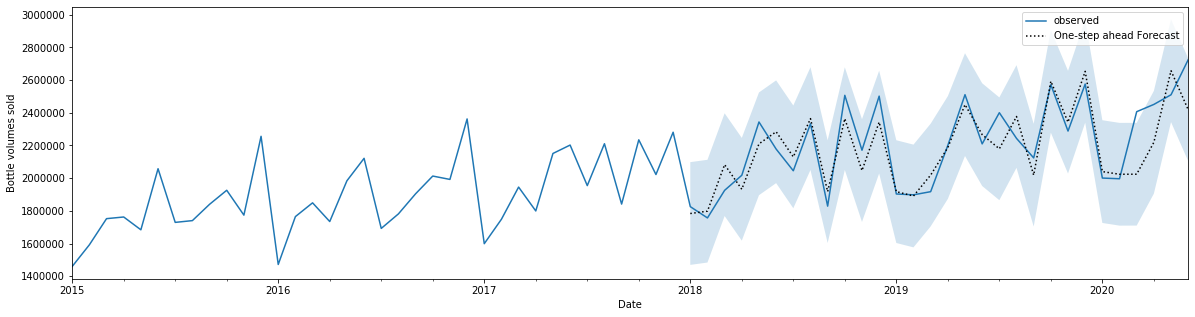

In [11]:
#by selecting 2015 we slice the ax to have a better, zoomed view
ax = y['2015':].plot(label='observed', figsize=(20, 5))
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast',linestyle = 'dotted', color = 'black')

#draw confidence intervals
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Bottle volumes sold')
plt.legend()

plt.show()


A first model evaluation can be given by calculating the MAE (Mean average error) and RMSE (Rooted mean square error)

In [12]:
y_forecast = pred.predicted_mean #take the values of the forecast line
y_actuals = y['2018':]

# Compute error values for the model
mae = abs(y_forecast - y_actuals).mean()
mse = ((y_forecast - y_actuals) ** 2).mean()
rmse = np.sqrt(mse)
mape = (abs(y_forecast - y_actuals) / y_actuals).mean()

print('The Mean Absolute Error of our forecasts is {}'.format(round(mae, 2)))
print('The Mean Absolute Percentage Error of our forecasts is {}'.format(round(mape, 4)))
print('The Rooted Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))


The Mean Absolute Error of our forecasts is 106693.44
The Mean Absolute Percentage Error of our forecasts is 0.0467
The Rooted Mean Squared Error of our forecasts is 137237.23


To have a better grasp, a good call would be to put together the two series and check for errors:
- Magnitude  
- Location in time


In [13]:
#prepare data in a simple dataframe
forecast_df = pd.merge(left= y_forecast.to_frame(name = 'forecast'),
                       right = pred_ci, 
                       how='inner', 
                       left_index = True, right_index = True #join them on the datetime indexes
                      )

forecast_df = pd.merge(y_actuals,
                       forecast_df,
                       right_index = True, left_index=True)

forecast_df['mape'] = abs(forecast_df['forecast'] / forecast_df['bottles_sold'] -1)
forecast_df

,bottles_sold,forecast,lower bottles_sold,upper bottles_sold,mape
month,,,,,
2018-01-01,1825656,1.783556e+06,1.469095e+06,2.098017e+06,0.023060
2018-02-01,1756603,1.797881e+06,1.483420e+06,2.112342e+06,0.023499
2018-03-01,1925462,2.082682e+06,1.768221e+06,2.397143e+06,0.081653
2018-04-01,2017589,1.931947e+06,1.617486e+06,2.246408e+06,0.042448
2018-05-01,2343951,2.210045e+06,1.895584e+06,2.524506e+06,0.057128
2018-06-01,2178069,2.284067e+06,1.969606e+06,2.598528e+06,0.048666
2018-07-01,2045236,2.130331e+06,1.815870e+06,2.444791e+06,0.041606
2018-08-01,2333500,2.364438e+06,2.049977e+06,2.678899e+06,0.013258
2018-09-01,1828704,1.917510e+06,1.603050e+06,2.231971e+06,0.048563


In [14]:
forecast_df.groupby(pd.Grouper(freq='Y')).mean()
#can also be written, as a more verbose variable, as follows:
#forecast_df.groupby(by=[ forecast_df.index.year]).agg('mean')

,bottles_sold,forecast,lower bottles_sold,upper bottles_sold,mape
month,,,,,
2018-12-31,2.119587e+06,2.104696e+06,1.790235e+06,2.419157e+06,0.046481
2019-12-31,2.237028e+06,2.241361e+06,1.926901e+06,2.555822e+06,0.032014
2020-12-31,2.348442e+06,2.230726e+06,1.916265e+06,2.545186e+06,0.076359


From this view there is evidence the model is getting dizzier in 2020, where in February and March very different trends can be observed against the history of these months.

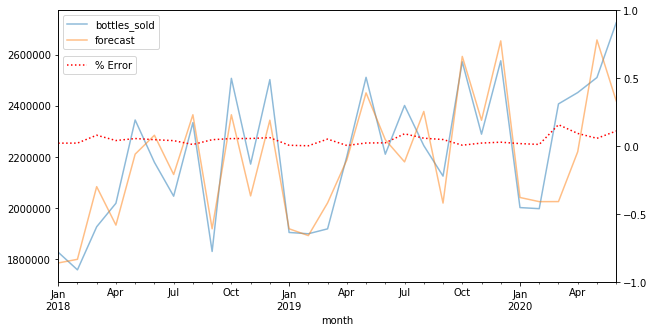

In [15]:
ax = forecast_df[['bottles_sold', 'forecast']].plot(alpha = 0.5, figsize = (10,5))

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
forecast_df['mape']['2018':].plot(ax=ax2, label='% Error',linestyle = 'dotted', color = 'red')

#ax.set_ylim(0,4000000)
ax2.set_ylim(-1, 1)
ax2.set_yticks(np.arange(-1,1.1, step=0.5))

plt.legend(loc='upper left', bbox_to_anchor=(0, 0.85))
plt.show()

## 3.2 Dynamic forecast
However, a better representation of our true predictive power can be obtained using dynamic forecasts.  
In this case, we only use information from the time series up to a certain point, and after that, forecasts are generated using values from previous forecasted time points.

In [16]:
#compute forecasts from 2018 onwards. do not use further data points. We expect this to INCREASE THE ERROR. 
pred_dynamic = results.get_prediction(start=pd.to_datetime('2018-01-01'), 
                                      dynamic=True, 
                                      full_results=True)

pred_dynamic_ci = pred_dynamic.conf_int()

y_dynamic_fc = pred_dynamic.predicted_mean
y_dynamic_fc.head()

2018-01-01    1.783556e+06
2018-02-01    1.808789e+06
2018-03-01    2.062531e+06
2018-04-01    1.898848e+06
2018-05-01    2.264509e+06
Freq: MS, dtype: float64

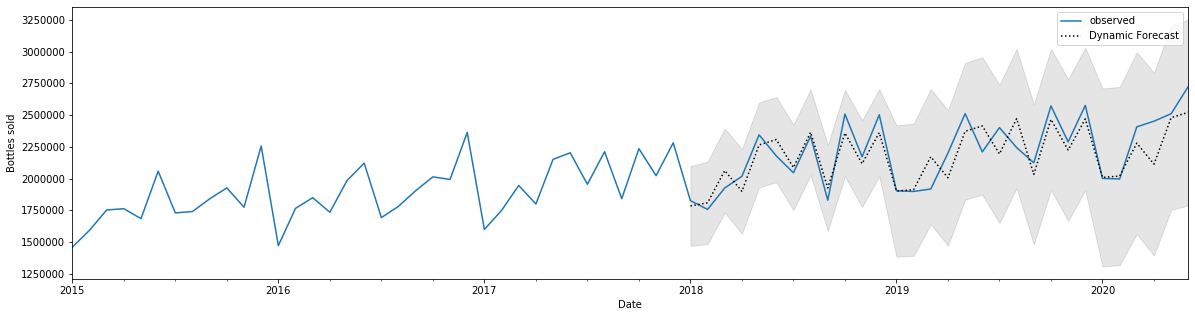

In [17]:
ax = y['2015':].plot(label='observed', figsize=(20, 5)) #base graph
y_dynamic_fc.plot(label='Dynamic Forecast', linestyle = 'dotted', color = 'black', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.1)

#ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2019-01-01'), y.index[-1],
#                alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Bottles sold')

plt.legend()
plt.show()


In [18]:
dynamicmerged = pd.merge(left= y_actuals, right = y_dynamic_fc.to_frame(), how='left', left_index = True, right_index = True)
dynamicmerged.rename(columns={0:'forecast'}, inplace = True) 

dynamicmerged['mape'] = abs(dynamicmerged['forecast']/dynamicmerged['bottles_sold']-1)
dynamicmerged['forecast'] = round(dynamicmerged['forecast'])
dynamicmerged.tail()

,bottles_sold,forecast,mape
month,,,
2020-02-01,1996321,2019382.0,0.011552
2020-03-01,2406919,2278625.0,0.053302
2020-04-01,2451397,2112828.0,0.138113
2020-05-01,2510415,2479301.0,0.012394
2020-06-01,2724971,2521169.0,0.074791


In [19]:
dynamicmerged.groupby(pd.Grouper(freq='Y')).mean()

,bottles_sold,forecast,mape
month,,,
2018-12-31,2.119587e+06,2.111477e+06,0.041888
2019-12-31,2.237028e+06,2.219383e+06,0.059957
2020-12-31,2.348442e+06,2.236629e+06,0.049011


In [20]:
print('The Mean Absolute Percentage Error of our forecasts is {}'.format(round(abs(dynamicmerged["mape"]).mean(), 4)))

The Mean Absolute Percentage Error of our forecasts is 0.0505


Both with Static and Dynamic forecast we have found a decent model, with a 4-5% Mean Absolute Percentage Error.

# 4. Predicting the future
After we have validated the forecast with acceptable error ranges, we can actually start predicting the future.

- This shall be done with the `get_forecast()` attribute, to generate a `future` dataframe.  
With it, the time series object can compute forecasted values for a specified number of steps ahead.
- Then we can take the previous optimal model with `forecast_df`, and append `future` to it.


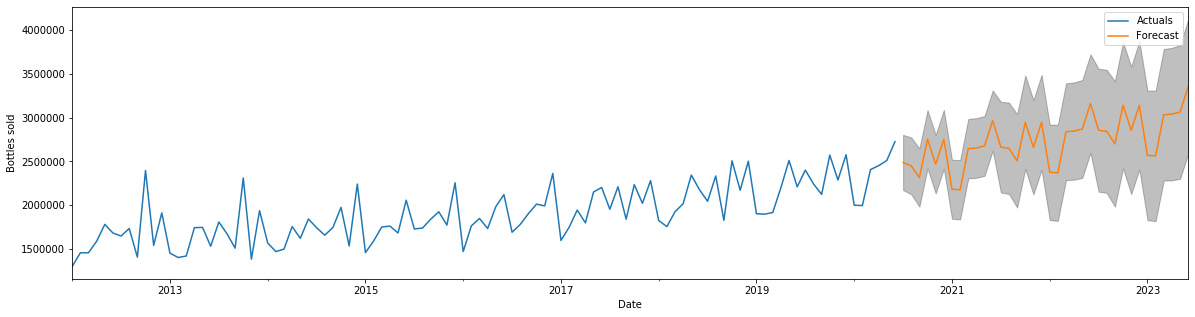

In [21]:
# Get forecast 3-years ahead in future and confidence intervals
pred_uc = results.get_forecast(steps=36)
pred_ci = pred_uc.conf_int()


#plotting of series
ax = y.plot(label='Actuals', figsize=(20, 5))       #plot starting data on bottles sold (y)
pred_uc.predicted_mean.plot(ax=ax, label='Forecast') #plot forecast


#handle confidence intervals
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)


#labels
ax.set_xlabel('Date')
ax.set_ylabel('Bottles sold')

plt.legend()
plt.show()


In [22]:
future = pd.merge(left= pred_uc.predicted_mean.to_frame(name = 'forecast'),
                  right = pred_ci,
                  how='left',
                  left_index = True, right_index = True
                        )

future['bottles_sold'] = np.nan
future['mape'] = np.nan

future.head()

,forecast,lower bottles_sold,upper bottles_sold,bottles_sold,mape
2020-07-01,2.488206e+06,2.173746e+06,2.802667e+06,NaN,NaN
2020-08-01,2.449143e+06,2.124298e+06,2.773989e+06,NaN,NaN
2020-09-01,2.315557e+06,1.983123e+06,2.647991e+06,NaN,NaN
2020-10-01,2.752874e+06,2.420217e+06,3.085532e+06,NaN,NaN
2020-11-01,2.468316e+06,2.133860e+06,2.802772e+06,NaN,NaN


In [23]:
output = forecast_df.append(future)
output

,bottles_sold,forecast,lower bottles_sold,upper bottles_sold,mape
2018-01-01,1825656.0,1.783556e+06,1.469095e+06,2.098017e+06,0.023060
2018-02-01,1756603.0,1.797881e+06,1.483420e+06,2.112342e+06,0.023499
2018-03-01,1925462.0,2.082682e+06,1.768221e+06,2.397143e+06,0.081653
2018-04-01,2017589.0,1.931947e+06,1.617486e+06,2.246408e+06,0.042448
2018-05-01,2343951.0,2.210045e+06,1.895584e+06,2.524506e+06,0.057128
...,...,...,...,...,...
2023-02-01,NaN,2.563172e+06,1.818893e+06,3.307451e+06,NaN
2023-03-01,NaN,3.031548e+06,2.281432e+06,3.781664e+06,NaN
2023-04-01,NaN,3.039307e+06,2.283425e+06,3.795188e+06,NaN
2023-05-01,NaN,3.063052e+06,2.301439e+06,3.824665e+06,NaN


# The quicker way: Prophet
Arima looks great and is indeed foundational in understanding how time series can be decomposed and modeled, but is painful to set up. There are a handful of very quick ways to test other models, one being a library from Facebook: [Prophet](https://facebook.github.io/prophet/).

In [24]:
from fbprophet import Prophet
from fbprophet.plot import plot_plotly
from fbprophet.diagnostics import  performance_metrics,cross_validation
from fbprophet.plot import add_changepoints_to_plot
import plotly.offline as py

py.init_notebook_mode(connected=True)

#plt.style.use('default')

In [25]:
#As done in the beginning we need a column that is in datetime format, converting the current string 
iowa = raw_data
iowa['month'] = pd.to_datetime(iowa['month'])

#change column names according to prophet expected format
iowa = iowa.rename(columns={'month': 'ds',
                        'bottles_sold': 'y'})

print(iowa.dtypes)
iowa.head()

ds                  datetime64[ns]
number_of_stores             int64
y                            int64
dtype: object


,ds,number_of_stores,y
0,2012-01-01,973,1302231
1,2012-02-01,988,1457824
2,2012-03-01,1004,1458665
3,2012-04-01,1019,1588914
4,2012-05-01,1021,1782175


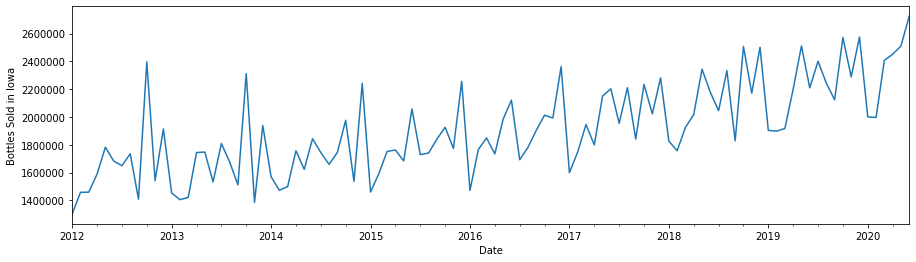

In [26]:
ax = iowa.set_index('ds')['y'].plot(figsize=(15, 4))
ax.set_ylabel('Bottles Sold in Iowa')
ax.set_xlabel('Date')

plt.show()


##  Fit and predict

The fit and predict process in Prophet is straightforward:
1. **Instantiate** a `Prophet()` object (your model) and include all the parameter optimizations therein. Add regressors, seasonality, whatever you want.  


2. **Fit** the model with your chosen dataframe. As long as you have the y + ds you will be good.  


3. **Predict** the future, if any.  
A simple line such  `forecast = m.predict()` will return you a dataframe with the estimates for your existing model.


4. **Plot** results and check for model errors.

In [27]:
# 1. - instantiate a standard Prophet object and fit it with your chosen dataset
m = Prophet()

# 2. - Fit the model with your starting dataframe
forecast = m.fit(iowa)

#Create your future dataframe...
future = m.make_future_dataframe(periods=36, freq='MS')

# 3. predict the future! 
#Consider that, if you have regressors in the model, you will need to factor them in also here.
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
133,2023-02-01,2.463725e+06,2.304662e+06,2.618061e+06
134,2023-03-01,2.531238e+06,2.382188e+06,2.683872e+06
135,2023-04-01,2.691667e+06,2.538129e+06,2.843004e+06
136,2023-05-01,2.808296e+06,2.649808e+06,2.957445e+06
137,2023-06-01,2.820082e+06,2.671240e+06,2.976026e+06


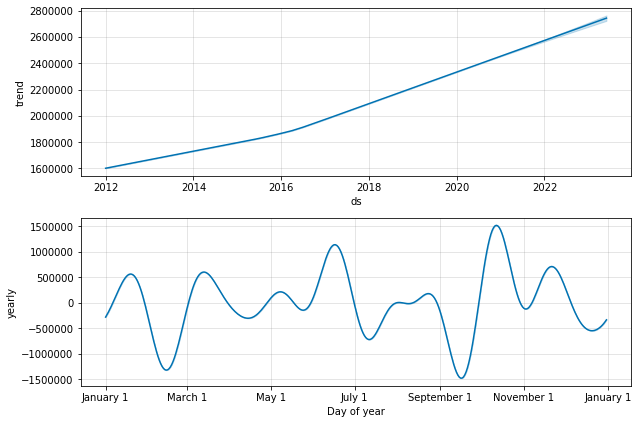

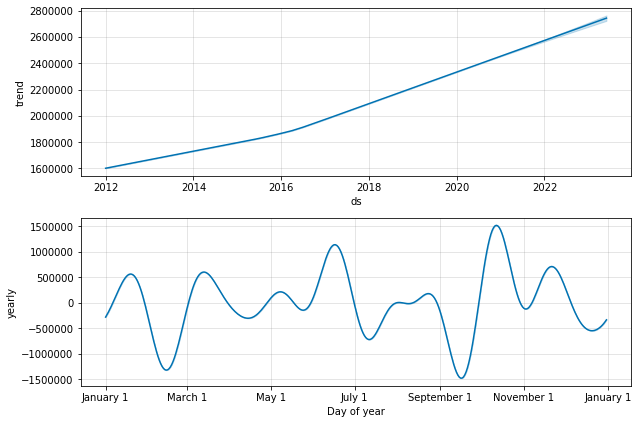

In [28]:
#4. Interactive Graph + trend components
fig = plot_plotly(m, forecast)
py.iplot(fig)

m.plot_components(forecast)

This is the pure, baseline seasonal trend.  
Let's check how it performs with the overall thing, which **requires us to merge the actuals with the forecasted values.**

In [29]:
fcst = pd.merge(left = iowa,
                 right = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']],
                 how = 'left',
                 on = 'ds')

fcst['mae'] = abs(fcst['yhat'] - fcst['y'])
fcst['mape'] = fcst['mae'] / fcst['y']

fcst['mape'].mean()

0.050419806425555366

Mmmh pretty good! In a few lines of code we managed to get a very decent **mape of 5%** - it is still very in line with all the stuff we deployed with the ARIMA model, except is a billion times faster and required no parameter optimization.  

We can try to finetune the model using the optional available parameters, as well as considering to remove some outliers that screw up the forecast. First though it can be useful to define some functions to speed this thing up.  

The desired outcome is to have functions that allow us to:
- Evaluate a model performance against a given timeseries
- Be able to project a forecast for as many time units as needed
- Return a Dataframe with the results and plot data

For exportability, we will condense them into a generic `Seer` class, basically a wrapper of a `Prophet` object, to help us test models more quickly.

In [30]:
from seer_class import Seer
seer = Seer()

## Simulating future scenarios with a regressor
Let's try a test now, assuming we know how the base of stores selling alcoholic beverages will increase in time - to do this we will create some random progression with some noise (in a -/+ fork)

In [32]:
import random 
random.seed(1) #set seed for reproducibility

dates = pd.date_range(start = '2020-06-01', periods = 40, freq='MS')

#generate a random progression of fake stores to simulate a growth over time
fake_stores = []
start = iowa.iloc[-1][1]

for i in range(0,40):
    rand = random.randint(-20, 40)
    start += rand
    fake_stores.append(start)   


d = {'ds': dates, 'number_of_stores': fake_stores}
future_regressor = pd.DataFrame(data=d)

present_and_future_regr = iowa[['ds', 'number_of_stores']].append(future_regressor)
present_and_future_regr

,ds,number_of_stores
0,2012-01-01,973
1,2012-02-01,988
2,2012-03-01,1004
3,2012-04-01,1019
4,2012-05-01,1021
...,...,...
35,2023-05-01,2079
36,2023-06-01,2116
37,2023-07-01,2116
38,2023-08-01,2097


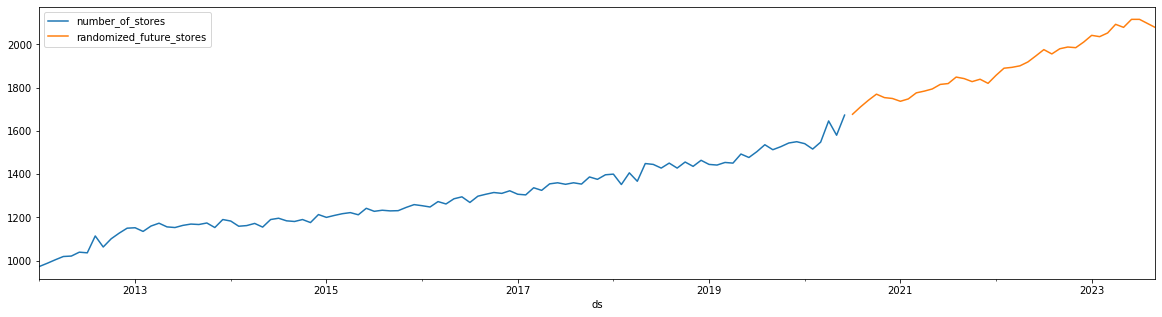

In [33]:
future_stores= present_and_future_regr.iloc[iowa.shape[0]+1:]
future_stores.columns = ['ds', 'randomized_future_stores']

#plotting of series
ax = iowa[['ds','number_of_stores']].set_index('ds').plot(label='stores', figsize=(20, 5))
future_stores.set_index('ds').plot(ax=ax, label='future') #plot forecast

The Mean Absolute Percentage Error of our forecasts is 0.0479


,ds,number_of_stores,y,yhat,yhat_lower,yhat_upper,mae,mape
0,2012-01-01,973,1302231.0,1.199805e+06,1.056555e+06,1.345770e+06,102425.784525,0.078654
1,2012-02-01,988,1457824.0,1.348628e+06,1.199196e+06,1.491446e+06,109195.737138,0.074903
2,2012-03-01,1004,1458665.0,1.463825e+06,1.318670e+06,1.615923e+06,5159.747109,0.003537
3,2012-04-01,1019,1588914.0,1.495834e+06,1.346764e+06,1.649682e+06,93079.702771,0.058581
4,2012-05-01,1021,1782175.0,1.663366e+06,1.519802e+06,1.814704e+06,118808.922940,0.066665
...,...,...,...,...,...,...,...,...
139,2023-05-01,2079,NaN,3.205614e+06,3.064703e+06,3.352485e+06,NaN,NaN
140,2023-06-01,2116,NaN,3.252721e+06,3.111427e+06,3.390905e+06,NaN,NaN
141,2023-07-01,2116,NaN,3.212705e+06,3.067037e+06,3.362660e+06,NaN,NaN
142,2023-08-01,2097,NaN,3.154446e+06,3.011837e+06,3.301117e+06,NaN,NaN


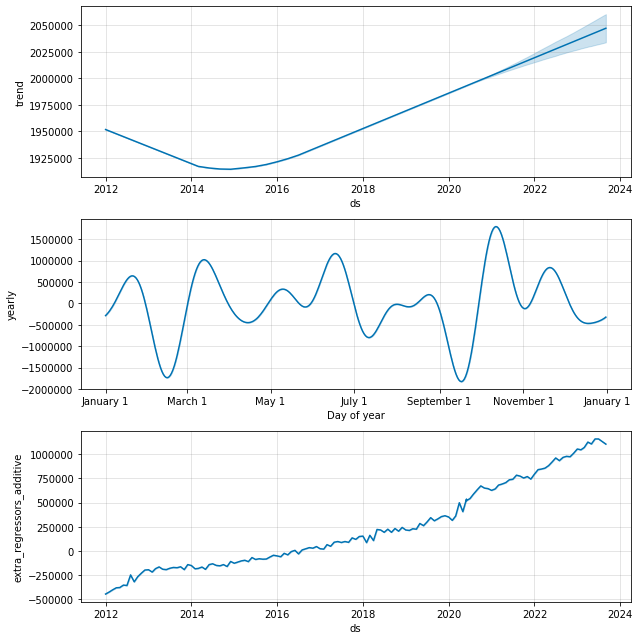

In [34]:
m2 = Prophet(
            interval_width=0.8,
            changepoint_prior_scale= 0.05, 
            yearly_seasonality = 10,
            weekly_seasonality=False,
            daily_seasonality=False
)

m2.add_regressor('number_of_stores')

forecast_3y = seer.test_model(m2, iowa, present_and_future_regr, viz = True)
forecast_3y


In [35]:
forecast_3y

,ds,number_of_stores,y,yhat,yhat_lower,yhat_upper,mae,mape
0,2012-01-01,973,1302231.0,1.199805e+06,1.056555e+06,1.345770e+06,102425.784525,0.078654
1,2012-02-01,988,1457824.0,1.348628e+06,1.199196e+06,1.491446e+06,109195.737138,0.074903
2,2012-03-01,1004,1458665.0,1.463825e+06,1.318670e+06,1.615923e+06,5159.747109,0.003537
3,2012-04-01,1019,1588914.0,1.495834e+06,1.346764e+06,1.649682e+06,93079.702771,0.058581
4,2012-05-01,1021,1782175.0,1.663366e+06,1.519802e+06,1.814704e+06,118808.922940,0.066665
...,...,...,...,...,...,...,...,...
139,2023-05-01,2079,NaN,3.205614e+06,3.064703e+06,3.352485e+06,NaN,NaN
140,2023-06-01,2116,NaN,3.252721e+06,3.111427e+06,3.390905e+06,NaN,NaN
141,2023-07-01,2116,NaN,3.212705e+06,3.067037e+06,3.362660e+06,NaN,NaN
142,2023-08-01,2097,NaN,3.154446e+06,3.011837e+06,3.301117e+06,NaN,NaN


# Wrapup
In this project we have seen:
- How to connect to a bigquery client with ease to retrieve data
- How to set up an ARIMA / SARIMA model
- How to analyze timeseries with Prophet
- Defined a useful class that can be imported in future projects to quickly test different Prophet models.